In [1]:
!pip install torch torchvision torchaudio
!pip install torchsummary

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from google.colab import drive
import matplotlib.pyplot as plt
import random
from torchsummary import summary
# drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


!git --version



cuda
git version 2.34.1


In [2]:
!eval "$(ssh-agent -s)"; ssh-add /kaggle/input/github-key/kaggle_key;ssh-add -l;

Agent pid 80
Identity added: /kaggle/input/github-key/kaggle_key (mohammeddanishrabbani@gmail.com)
4096 SHA256:0c0hTdGW8vLpJlNSK8yv31bv4vNUN2TaFpe3NTJVEB8 mohammeddanishrabbani@gmail.com (RSA)


In [3]:
!eval "$(ssh-agent -s)"; ssh-add /kaggle/input/github-key/kaggle_key;ssh-add -l;export GIT_SSH_COMMAND="ssh -o StrictHostKeyChecking=no";git clone git@github.com:mohammeddanishrabbani/vr_mini_project.git

Agent pid 84
Identity added: /kaggle/input/github-key/kaggle_key (mohammeddanishrabbani@gmail.com)
4096 SHA256:0c0hTdGW8vLpJlNSK8yv31bv4vNUN2TaFpe3NTJVEB8 mohammeddanishrabbani@gmail.com (RSA)
Cloning into 'vr_mini_project'...
remote: Enumerating objects: 4018, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 4018 (delta 12), reused 18 (delta 12), pack-reused 3999 (from 1)
Receiving objects: 100% (4018/4018), 196.84 MiB | 46.69 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (4108/4108), done.


In [4]:
WORKING_DIRECTORY = '/kaggle/working/vr_mini_project'




In [5]:
dataset_path = f"{WORKING_DIRECTORY}/classification_dataset"
model_path = f"{WORKING_DIRECTORY}/cnn_models"



In [6]:

def load_dataset(dataset_path,split_ratio=0.80,batch_size=32):

  train_transform = transforms.Compose([
      transforms.Resize((128, 128)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])


  val_transform = transforms.Compose([
      transforms.Resize((128, 128)),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])

  #creating the  dataset
  dataset = ImageFolder(root=dataset_path)
  # Get class names
  class_names = dataset.classes
  print("Classes:", class_names)
  print("Number of images:", len(dataset))
  print("Number of classes:", len(class_names))


  fig, axes = plt.subplots(1, 5, figsize=(12, 4))  # Display 5 images

  for i in range(5):
      idx = random.randint(0, len(dataset) - 1)  # Random index
      image, label = dataset[idx]  # Load image and label
      axes[i].imshow(image)  # Display PIL image
      axes[i].set_title(f"{class_names[label]}\n Shape:{image.size}")  # Show class name
      axes[i].axis("off")



  train_size = int(split_ratio * len(dataset))

  #creating traning and validation dataset
  val_size = len(dataset) - train_size
  train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

  train_data.dataset.transform = train_transform
  val_data.dataset.transform = val_transform

  print("Number of training images:", len(train_data))
  print("Number of validation images:", len(val_data))




  # Create DataLoaders
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader







In [15]:
import torch.nn as nn
import torch.nn.functional as F

# Define CNN Model
class MaskCNN(nn.Module):
    def __init__(self):
        super(MaskCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x



def training(num_epochs, model,loss_function,optimizer,train_loader,val_loader,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer"):

  if model_weights_path is not None:
    model.load_state_dict(torch.load(model_weights_path))

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  best_validation_accracy = 0
  for epoch in range(start_epoch, num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device).float().view(-1, 1)

          optimizer.zero_grad()
          outputs = model(images)
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          predictions = (outputs > 0.5).float()
          correct_train += (predictions == labels).sum().item()
          total_train += labels.size(0)

      train_loss = running_loss / len(train_loader)
      train_acc = correct_train / total_train
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      # Validation
      model.eval()
      correct_val = 0
      total_val = 0
      running_val_loss = 0.0


      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device).float().view(-1, 1)
              outputs = model(images)
              loss = loss_function(outputs, labels)
              running_val_loss += loss.item()

              predictions = (outputs > 0.5).float()
              correct_val += (predictions == labels).sum().item()
              total_val += labels.size(0)

      val_loss = running_val_loss / len(val_loader)
      val_acc = correct_val / total_val
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      if val_acc > best_validation_accracy:
          print(f"best model at {epoch+1}")
          torch.save(model.state_dict(), f"{model_path}/{model_name}_best_model.pth")
          best_validation_accracy = val_acc
      print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
  model.load_satte_dict(torch.load(f"{model_path}/{model_name}_best_model.pth"))
  return model, train_losses, val_losses, train_accuracies, val_accuracies







In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies):
  num_epochs = len(train_losses)
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
  plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='s')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training vs Validation Accuracy")
  plt.legend()
  plt.grid()
  plt.show()




In [9]:
def compute_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask", "No Mask"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()



Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2
Number of training images: 3275
Number of validation images: 819
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
----------------------------------------------------------------
Input 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


best model at 1
Epoch 1: Train Loss: 0.3259, Train Acc: 0.8660, Val Loss: 0.2767, Val Acc: 0.9084
best model at 2
Epoch 2: Train Loss: 0.2207, Train Acc: 0.9197, Val Loss: 0.1849, Val Acc: 0.9194
best model at 3
Epoch 3: Train Loss: 0.1770, Train Acc: 0.9365, Val Loss: 0.1480, Val Acc: 0.9365
best model at 4
Epoch 4: Train Loss: 0.1591, Train Acc: 0.9444, Val Loss: 0.1352, Val Acc: 0.9451
best model at 5
Epoch 5: Train Loss: 0.1371, Train Acc: 0.9487, Val Loss: 0.1573, Val Acc: 0.9463
best model at 6
Epoch 6: Train Loss: 0.1250, Train Acc: 0.9536, Val Loss: 0.1028, Val Acc: 0.9597
best model at 7
Epoch 7: Train Loss: 0.1052, Train Acc: 0.9637, Val Loss: 0.1023, Val Acc: 0.9658
Epoch 8: Train Loss: 0.0803, Train Acc: 0.9701, Val Loss: 0.1205, Val Acc: 0.9512
Epoch 9: Train Loss: 0.0597, Train Acc: 0.9789, Val Loss: 0.1376, Val Acc: 0.9634
best model at 10
Epoch 10: Train Loss: 0.0501, Train Acc: 0.9805, Val Loss: 0.1028, Val Acc: 0.9731
best model at 11
Epoch 11: Train Loss: 0.0320, Tra

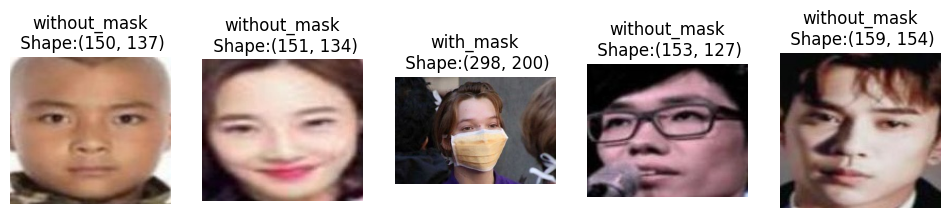

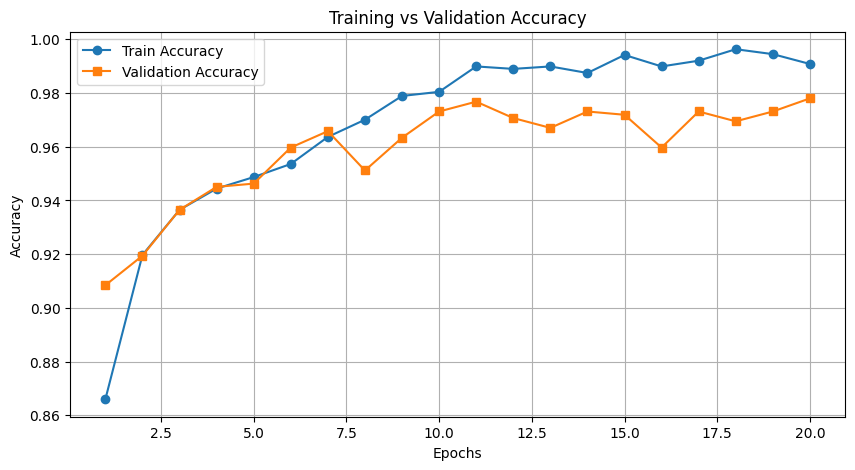

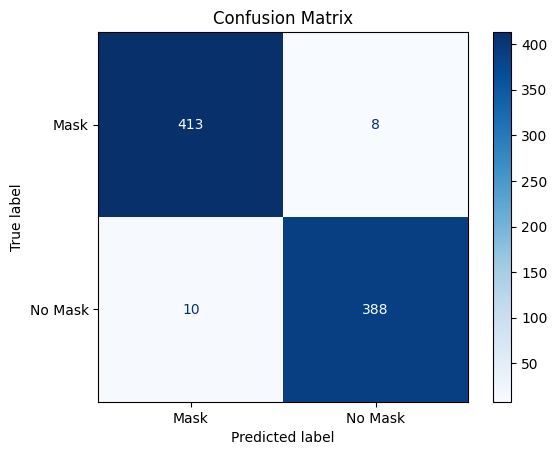

In [10]:


import os

model_path = f"{WORKING_DIRECTORY}/cnn_models/3_layer_cnn_sigmoid_adam"
os.makedirs(model_path, exist_ok=True)

def cnn_3_layer():
    train_loader,val_loader = load_dataset(dataset_path)
    lr = 0.001
    num_epochs = 20
    model = MaskCNN()
    model.to(device)
    summary(model, input_size = (3, 128, 128))
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    
    
    model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs, model,loss_function,optimizer,train_loader,val_loader,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer")
    train_accuracies.extend(train_accuracy)
    val_accuracies.extend(val_accuracy)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)
    plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
    compute_confusion_matrix(model, val_loader)



cnn_3_layer()

    






In [12]:
!cd /kaggle/working/vr_mini_project;eval "$(ssh-agent -s)"; ssh-add /kaggle/input/github-key/kaggle_key;ssh-add -l;cd /kaggle/working/vr_mini_project;git config --global user.name "mohammeddanishrabbani";git config --global user.email "mohammeddanishrabbani@gmail.com";git checkout -b mrabbani_cnn_3_layer_20_epochs; git add .;git commit -m "a"; git push origin mrabbani_cnn_3_layer_20_epochs;

Agent pid 142
Identity added: /kaggle/input/github-key/kaggle_key (mohammeddanishrabbani@gmail.com)
4096 SHA256:0c0hTdGW8vLpJlNSK8yv31bv4vNUN2TaFpe3NTJVEB8 mohammeddanishrabbani@gmail.com (RSA)
Switched to a new branch 'mrabbani_cnn_3_layer_20_epochs'
On branch mrabbani_cnn_3_layer_20_epochs
nothing to commit, working tree clean
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 15.20 MiB | 12.11 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: 
remote: Create a pull request for 'mrabbani_cnn_3_layer_20_epochs' on GitHub by visiting:
remote:      https://github.com/mohammeddanishrabbani/vr_mini_project/pull/new/mrabbani_cnn_3_layer_20_epochs
remote: 
To github.com:mohammeddanishrabbani/vr_mini_project.git
 * [new branch]      mrabbani_cnn_3_layer_20_epochs -> mrabbani_cnn

Model training with high learning rate
Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2
Number of training images: 3275
Number of validation images: 819
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
--------------------------------

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


best model at 1
Epoch 1: Train Loss: 51.8351, Train Acc: 0.4757, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 2: Train Loss: 52.5651, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 3: Train Loss: 52.6230, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 4: Train Loss: 52.7968, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 5: Train Loss: 52.6230, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 6: Train Loss: 52.6230, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 7: Train Loss: 52.3913, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 8: Train Loss: 52.4492, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 9: Train Loss: 52.5072, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 10: Train Loss: 52.5651, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 11: Train Loss: 52.5072, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 12: Train Loss: 52.3913, Train Acc: 0.4739, Val Loss

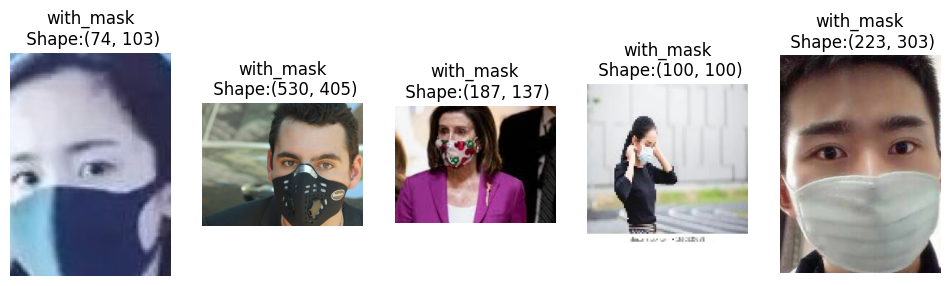

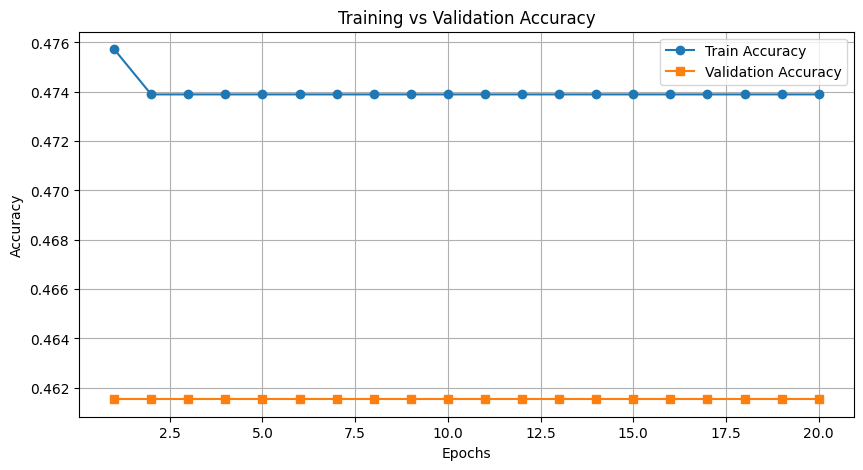

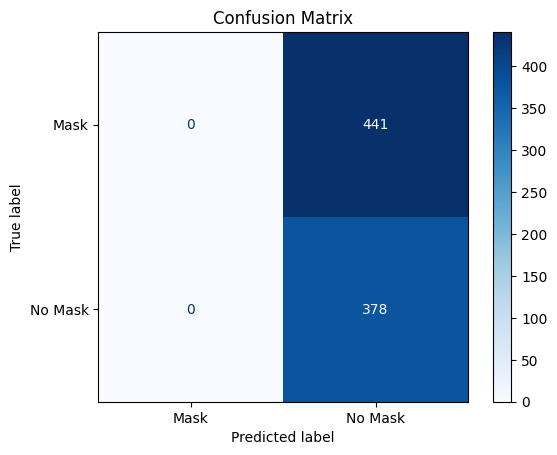

In [14]:
model_path = f"{WORKING_DIRECTORY}/cnn_models/3_layer_cnn_sigmoid_adam_learning_rate_0.01"
os.makedirs(model_path, exist_ok=True)

def cnn_3_layer_high_lr():
    train_loader,val_loader = load_dataset(dataset_path)
    lr = 0.01
    num_epochs = 20
    model = MaskCNN()
    model.to(device)
    summary(model, input_size = (3, 128, 128))
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    
    
    model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs, model,loss_function,optimizer,train_loader,val_loader,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer_lr_0.01")
    train_accuracies.extend(train_accuracy)
    val_accuracies.extend(val_accuracy)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)
    plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
    
    compute_confusion_matrix(model, val_loader)


print("Model training with high learning rate")

cnn_3_layer_high_lr()



In [17]:
!cd /kaggle/working/vr_mini_project;eval "$(ssh-agent -s)"; ssh-add /kaggle/input/github-key/kaggle_key;ssh-add -l;cd /kaggle/working/vr_mini_project;git config --global user.name "mohammeddanishrabbani";git config --global user.email "mohammeddanishrabbani@gmail.com";git checkout mrabbani_cnn_3_layer_20_epochs; git add .;git commit -m "a"; git push origin mrabbani_cnn_3_layer_20_epochs;

Agent pid 225
Identity added: /kaggle/input/github-key/kaggle_key (mohammeddanishrabbani@gmail.com)
4096 SHA256:0c0hTdGW8vLpJlNSK8yv31bv4vNUN2TaFpe3NTJVEB8 mohammeddanishrabbani@gmail.com (RSA)
Already on 'mrabbani_cnn_3_layer_20_epochs'
On branch mrabbani_cnn_3_layer_20_epochs
nothing to commit, working tree clean
Everything up-to-date
